In [1]:
import pandas as pd
import polars as pl
from sklearn.metrics import average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

In [3]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_renaming = model_metadata.set_index("name")["description"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN_final,GPN-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,hotpink
8,CADD+GPN-MSA+Borzoi,Ensemble,C8
9,Sei,Sei,C9


In [4]:
dataset_renaming = {
    "mendelian_traits_all": "Mendelian traits",
    "complex_traits_all": "Complex traits",
}

subset_renaming = {
    "all": "All",
}

In [5]:
datasets = [
    "mendelian_traits_all",
    "complex_traits_all",
]

subsets = {
    "mendelian_traits_all": [
        "all",
    ],
    "complex_traits_all": [
        "maf_match",
    ],
}

models = [
    "CADD",
    "GPN-MSA",
    "phyloP-100v",
    "phyloP-241m",
    "phastCons-43p",
]

model_zero_shot_score = {
    "mendelian_traits_all": {
        "CADD": "CADD.plus.RawScore",
        "GPN-MSA": "GPN-MSA_LLR.minus.score",
        "phyloP-100v": "phyloP-100v.plus.score",
        "phyloP-241m": "phyloP-241m.plus.score",
        "phastCons-43p": "phastCons-43p.plus.score",
    },
    "complex_traits_all": {
        "CADD": "CADD.plus.RawScore",
        "GPN-MSA": "GPN-MSA_absLLR.plus.score",
        "phyloP-100v": "phyloP-100v.plus.score",
        "phyloP-241m": "phyloP-241m.plus.score",
        "phastCons-43p": "phastCons-43p.plus.score",
    },
}

metric = "AUPRC"

def get_model_path(model, dataset, subset, metric):
    predictor = model_zero_shot_score[dataset][model]
    return f"../../results/dataset/{dataset}/{metric}/{subset}/{predictor}.csv"

In [6]:
rows = []
for dataset in datasets:
    V = pl.read_parquet(f"../../results/dataset/{dataset}/test.parquet")
    for subset in subsets[dataset]:
        s = pl.read_parquet(f"../../results/dataset/{dataset}/subset/{subset}.parquet")
        V_s = V.join(s, on=["chrom", "pos", "ref", "alt"], how="inner")
        n_pos = V_s["label"].sum()
        n_neg = len(V_s) - n_pos
        for model in models:
            path = get_model_path(model, dataset, subset, metric)
            df = pd.read_csv(path).iloc[0]
            rows.append([
                dataset_renaming.get(dataset, dataset),
                subset_renaming.get(subset, subset),
                model_renaming.get(model, model),
                df[metric],
                df["se"],
                n_pos,
                n_neg,
            ])
df = pd.DataFrame(rows, columns=["dataset", "subset", "model", metric, "se", "n_pos", "n_neg"])
df

,dataset,subset,model,AUPRC,se,n_pos,n_neg
0,Mendelian traits,All,CADD,0.011185,0.001305,339,4945336
1,Mendelian traits,All,GPN-MSA,0.080031,0.016472,339,4945336
2,Mendelian traits,All,phyloP-100v,0.028014,0.009735,339,4945336
3,Mendelian traits,All,phyloP-241m,0.017425,0.002106,339,4945336
4,Mendelian traits,All,phastCons-43p,0.004676,0.000571,339,4945336
5,Complex traits,maf_match,CADD,0.003923,0.001202,1140,2924838
6,Complex traits,maf_match,GPN-MSA,0.002427,0.000543,1140,2924838
7,Complex traits,maf_match,phyloP-100v,0.001090,0.000116,1140,2924838
8,Complex traits,maf_match,phyloP-241m,0.002656,0.000432,1140,2924838
9,Complex traits,maf_match,phastCons-43p,0.002597,0.000302,1140,2924838


In [7]:
def new_title(x):
    n_pos = format_number(x.n_pos)
    n_neg = format_number(x.n_neg)
    return f"{x.dataset}\nn={n_pos} vs. {n_neg}"

df["title"] = df.apply(new_title, axis=1)

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

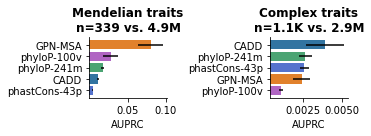

In [8]:
g = sns.FacetGrid(
    df,
    col="title",
    margin_titles=True,
    sharex="col",
    sharey=False,#"row",
    #height=1.8,
    #aspect=1.2,
    height=2,
    aspect=1.3,
)

def my_boxplot(data, **kwargs):
    data = data.sort_values(metric, ascending=False)
    n_pos = data["n_pos"].iloc[0]
    n_neg = data["n_neg"].iloc[0]
    baseline = n_pos / (n_pos + n_neg)
    ax = plt.gca()
    g = sns.barplot(
        data=data,
        y="model",
        x=metric,
        ax=ax,
        palette=palette,
        #showfliers=False, whis=0, # optional
    )
    ax.errorbar(
        x=data[metric],
        y=data["model"],
        xerr=data["se"],
        fmt='none',      # Do not add markers (those are already in the pointplot)
        color="black",
    )
    g.set(
        xlim=baseline if metric == "AUPRC" else 0.5,
    )

g.map_dataframe(my_boxplot)

g.set(
    ylabel="",
)
g.set_titles(
    col_template="{col_name}", row_template="{row_name}",
    fontweight="bold",
    size=12,
)
g.tight_layout()
plt.savefig(f"../../results/plots/performance_full_negatives_{metric}.pdf", bbox_inches="tight")